# Lab 2 - A first look at neural networks

---

This notebook contains the code samples found in Chapter 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

----

A machine-learning system is trained rather than being explicitly programmed. It’s presented with many examples relevant to a task, and it finds the statistical structure in these examples that eventually allows the system to come up with rules for automating the task. Specifically, machine learning needs three things:
 1. input data points,
 - examples of the expected output,
 - a way to measure whether the algorithm is doing a good job.

The above items are needed to determine the distance between the algorithm’s current output and its expected output. This measurement is used as a feedback signal to adjust the way the algorithm works. This adjustment step is what we call *learning*.

#### Learning representations from data

A machine-learning model transforms its input data into meaningful outputs, a process that is “learned” from exposure to known examples of inputs and outputs. Therefore, the central problem in machine learning is to meaningfully
transform data: in other words, to learn useful representations of the input data, in order to get us closer to the expected output. Before we go any further: what’s a representation? At its core, it’s a different way to look at data.

All machine-learning algorithms consist of automatically finding transformations that turn data into more useful representations for a given task. These operations can be linear projections, translations, nonlinear operations, and so on. Machine-learning algorithms aren’t usually creative in finding these transformations; they’re merely searching through a predefined set of operations, called a *hypothesis space*. That’s what machine learning is: searching for useful representations of some input data, within a predefined space of possibilities, using guidance from a feedback signal.

#### Deep learning

Deep learning is a specific subfield of machine learning: a new take on learning representations from data that puts an emphasis on learning successive *layers* of increasingly meaningful representations. These layered representations are (almost always) learned via models called *neural networks*. Modern deep learning often involves tens or even hundreds of successive layers of representations, and they’re all learned automatically from exposure to training data.

What do the representations learned by a deep-learning algorithm look like? Let’s examine how a network transforms an image in order to recognize its content. As you can see in the figure below, the network transforms the input image into representations that are increasingly different from the original image, and increasingly informative
about the final result. You can think of a deep network as a multistage information-distillation operation, where information goes through successive filters, and comes out increasingly purified with regard to some task.

![network.png](https://perso.esiee.fr/~najmanl/DeepLearning/network.png)


At this point, you know that machine learning is about mapping inputs to targets, which is done by observing many examples of input and targets. You also know that deep neural networks do this input-to-target mapping via a deep sequence of simple data transformations (layers), and that these data transformations are learned by exposure to examples. Now let’s look at how this learning happens, concretely.

# 1. Anatomy of a neural network

We will now take a look at a first concrete example of a neural network, which makes use of the Python library [Keras](https://keras.io).

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset, which contains a set of 60,000 training images, plus 10,000 test images. You can think of "solving" MNIST  as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

Our workflow will be as follow.

 1. Load the dataset.
 - Build the neural network.
 - Present the network with the training data, `train_images` and `train_labels`, in order to learn the association between images and labels.
 - Ask the network to produce predictions for `test_images`, and verify if these predictions match the labels from `test_labels`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from keras.datasets import mnist
from keras import models
from keras import layers

If you have not installed the libraries `keras` and `tensorflow`, please execute the following code via Anaconda Prompt. Then, reexecute the previous code to import the required packages.

In [ ]:
# pip install keras
# pip install tensorflow

Random seeds allow us to generate the same random values, ensuring reproducibility of results. The specific seed value is not important for now, but it is essential to use the same seed value for this exercise.

Therefore, add the following code at the beginning of the script. Each line is necessary, as it controls randomness in different parts of the code:

In [5]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

## 1.1 Dataset

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays (or tensors), and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data. In general, the first axis (axis=0) in all data tensors you’ll come across in deep learning will be the samples axis (sometimes called the samples dimension).

In [9]:
train_images.shape

(60000, 28, 28)

In addition, deep-learning models don’t process an entire dataset at once; rather, they break the data into small batches. Concretely, here’s one batch of our MNIST digits, with batch size of 10.

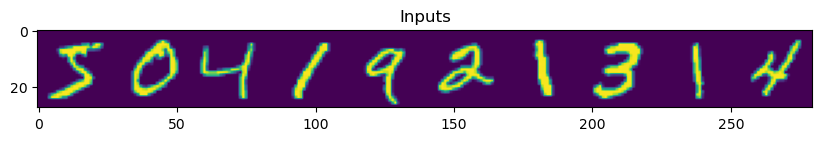

Labels: [5 0 4 1 9 2 1 3 1 4]


In [11]:
batch_size = 10

inputs = train_images[0:batch_size,:,:]
labels = train_labels[0:batch_size]

plt.figure(figsize=(10,5))
plt.imshow(np.hstack([inputs[i,:,:] for i in range(inputs.shape[0])]))
plt.title("Inputs")
plt.show()
print("Labels: " + str(labels))

And here’s another batch:

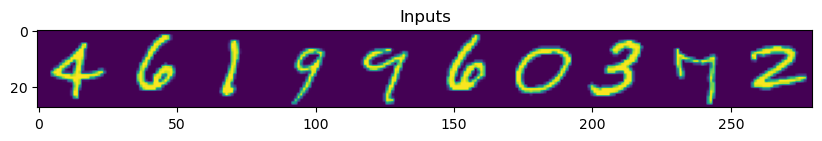

Labels: [4 6 1 9 9 6 0 3 7 2]


In [13]:
n = 15

inputs = train_images[n*batch_size : (n+1)*batch_size,:,:]
labels = train_labels[n*batch_size : (n+1)*batch_size]

plt.figure(figsize=(10,5))
plt.imshow(np.hstack([inputs[i,:,:] for i in range(inputs.shape[0])]))
plt.title("Inputs")
plt.show()
print("Labels: " + str(labels))

## 1.2 Network layers

The building block of neural networks is the **layer**, which can be thought of as a filter for data. Precisely, a layer is a data-processing module that takes as input one or more tensors, and outputs one or more transformed tensors. Some layers are stateless, but more frequently layers have a state: the **weights** (or parameters), which in essence are a bunch of numbers. The transformation implemented by a layer is parameterized by its weights.

Just as a reminder, here is an example of a single neuron

![Neuron](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-09-at-3-42-21-am.png?w=568&h=303)

and a fully connected network looks like this

![Fully connecte](https://www.gabormelli.com/RKB/images/thumb/4/44/2layersFCNN.png/300px-2layersFCNN.png)

In Keras, you just call some python function.
For example, a fully-connected layer looks like this in Keras:

```layers.Dense(512, activation='relu')```

This layer can be interpreted as a function, which takes as input a 2D tensor, and returns a transformed 2D tensor. Assuming that `W` and `b` are the layer's weighs, the function is as follows:

```output = relu(np.dot(input,W) + b)```

Let’s unpack this. We have three tensor operations here: a dot product (dot) between the input tensor and the 2D tensor `W`; an addition (+) between the resulting 2D tensor and the vector `b`; and, finally, a ReLU operation which computes `max(x, 0)` element-wise.

The argument being passed to a fully-connected layer is the number of "hidden units". Having 512 hidden units means that the weight matrix `W` will have shape `(input_dimension, 512)`. That is, the dot product with `W` will project the input data onto a 512-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). Intuitively, the number of hidden units controls "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units allows your network to learn more complex representations, but it makes your network more computationally expensive, and may lead to learning unwanted patterns.

Neural networks consist of layers clipped together to implement a form of progressive *data distillation*. The network topology constrains the *hypothesis space* to a specific series of operations, mapping input data to output data. In this context, learning means finding a set of values for the weights of all layers in a network, such that the network will correctly map example inputs to their associated targets.

The most common network is a linear stack of layers, mapping a single input to a single output. But even so, there are  two key architecture decisions to be made: how many layers to use, and how many hidden units to chose for each layer. Picking the right network architecture is more an art than a science. Although there are some best practices and principles you can rely on, only practice can help you become a proper neural-network architect.

![layer.png](https://perso.esiee.fr/~najmanl/DeepLearning/layer.png)

---

#### MNIST digit classification

To solve MNIST, we use a network with two `Dense` layers. The first one is a 512-dimensional ReLU layer, whereas the second (and last) one is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes. The code below is the way of building such a network in Keras.

In [16]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,))) # Fully-connected layers require a flattened vector : input_shape=(28*28,)
network.add(layers.Dense(10, activation='softmax')) # REMARK: softmax is for multi-class classification

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 1.3 Loss function and optimizer

Initially, right after the network architecture is defined, the parameters of all layers are filled with small random values (a step called random initialization). So, the network merely implements a series of random transformations. What comes next is to gradually adjust these parameters, based on the available data. This gradual adjustment is basically the *training* that machine learning is all about.

To make our network ready for training, we need to pick two more things.

- **Loss function**. To control the output of a neural network, we need to be able to measure how far this output is from what you expected. This is the job of the loss function of the network. The loss function takes the prediction of the network and the true target (what you wanted the network to output) and computes a distance score, capturing how well the network has done on this specific example.


- **Optimizer.** The fundamental trick in deep learning is to use this score as a feedback signal to adjust the value of the weights a little, in a direction that will lower the loss score for the current example. This adjustment is the job of the *optimizer*, which implements what’s called the *Backpropagation* algorithm.


Choosing the right loss function for the right problem is extremely important, as a network will take any shortcut it can to minimize the loss. So, if the loss doesn’t fully correlate with success for the task at hand, our network will end up doing things you may not have wanted. Fortunately, when it comes to common problems such as classification and regression, there are simple guidelines we can follow to choose the correct loss:
 - **Binary cross-entropy** for a two-class classification,
 - **Categorical cross-entropy** for a many-class classification problem,
 - **Mean squared error** for a regression problem.

![loss.png](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)


---

#### MNIST digit classification

As part of the "compilation" step, we prepare the training as follows:

 - The loss function is the categorical cross-entropy, as we are dealing with multiclass classification;
 - The optimizer is ADAM, an accelerated version of stochastic gradient descent.

Additionally, we ask the network to monitor a metric during training: the classification accuracy. (Note that `metrics` is an optional argument.)

In [19]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 1.4 Training

The training loop is where the network parameters are gradually adjusted. Within this loop, the following steps are repeated as long as necessary:
 1. Draw a batch of training samples `x` and corresponding targets `y`.
 - Run the network on `x` to obtain predictions `y_pred`.
 - Compute the loss of the network on the batch, a measure of the mismatch between `y_pred` and `y`.
 - Update all weights of the network in a way that slightly reduces the loss on this batch.

You’ll eventually end up with a network that has a very low loss on its training data: a low mismatch between predictions `y_pred` and expected targets `y`. The network has “learned” to map its inputs to outputs that are as close as they can be to the correct targets.

Step 1 sounds easy enough. Steps 2 and 3 are merely the application of a handful of tensor operations, so you could implement these steps purely from what you learned so far. The difficult part is step 4: updating the network’s weights. Given an individual weight coefficient in the network, how can you compute whether the coefficient should be increased or decreased, and by how much?

One naive solution would be to freeze all weights in the network except the one scalar coefficient being considered, and try different values for this coefficient. But such an approach would be horribly inefficient, because you’d need to compute multiple forward passes (which are expensive) for every individual coefficient (of
which there are many, usually thousands and sometimes up to millions). A much better approach is to take advantage of the fact that all operations used in the network are differentiable, and compute the gradient of the loss with regard to the network’s coefficients. You can then move the coefficients in the opposite direction from the gradient, thus decreasing the loss.

![training.png](https://machinelearningmastery.com/wp-content/uploads/2019/12/Learning-Curves-of-Cross-Entropy-Loss-for-a-Deep-Learning-Model.png)

---

#### MNIST digit classification

Before training, we preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in  the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with  values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [22]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels. This step is always required in multi-class classification, as the categoral cross-entropy loss expects the labels to be one-hot encoded.

In [24]:
print(test_labels)

[7 2 1 ... 4 5 6]


In [25]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [26]:
print(test_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network:
we "fit" the model to its training data.

In [28]:
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7274 - loss: 0.9988
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9300 - loss: 0.2517
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9497 - loss: 0.1852
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9590 - loss: 0.1464
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9669 - loss: 0.1200
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9721 - loss: 0.1006
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9766 - loss: 0.0856
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9794 - loss: 0.0737
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9827 - loss: 0.0642
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9855 - loss: 0.0564


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over the training data (as we specified a metric as part of the compilation step).

We quickly reach an accuracy of 0.986 (i.e. 98.6%) on the training data.

Note that the call to `model.fit()` returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

It contains 2 entries, one per metric that was being monitored during training:
 - `loss` - loss function
 - `accuracy` - classification accuracy.

Let's use Matplotlib to plot the training loss, as well as the training accuracy:

Training accuracy: 0.986050009727478


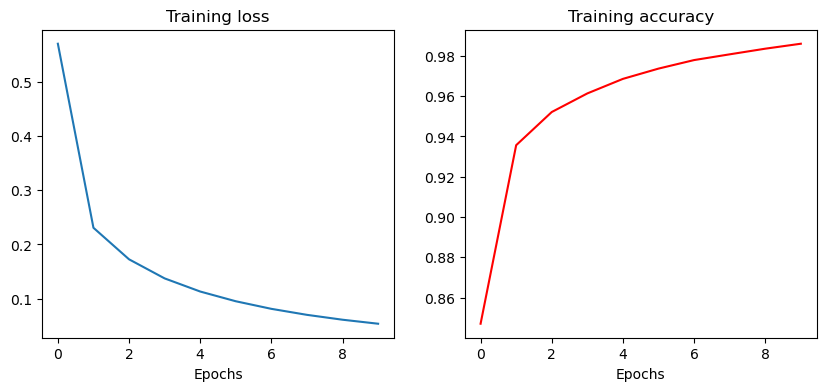

In [32]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(history.history['loss'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epochs')

ax2.plot(history.history['accuracy'],'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Epochs')

print('Training accuracy:', history.history['accuracy'][-1])

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration.

## 1.5 Prediction

After having trained a network, you will want to use it in a practical setting. You can generate the probability that the input digit image belongs to one of our 10 digit classes by using the `predict` method:

In [35]:
predictions = network.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


You can verify that the `predict` method returns a probability distribution over all 10 classes. Each entry in `predictions` is indeed a vector of length 10:

In [37]:
predictions[0].shape

(10,)

The coefficients in this vector sum to 1:

In [39]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, as it is the class with the highest probability:

In [41]:
np.argmax(predictions[0])

7

Concretely, here are the predictions for a batch of test images.

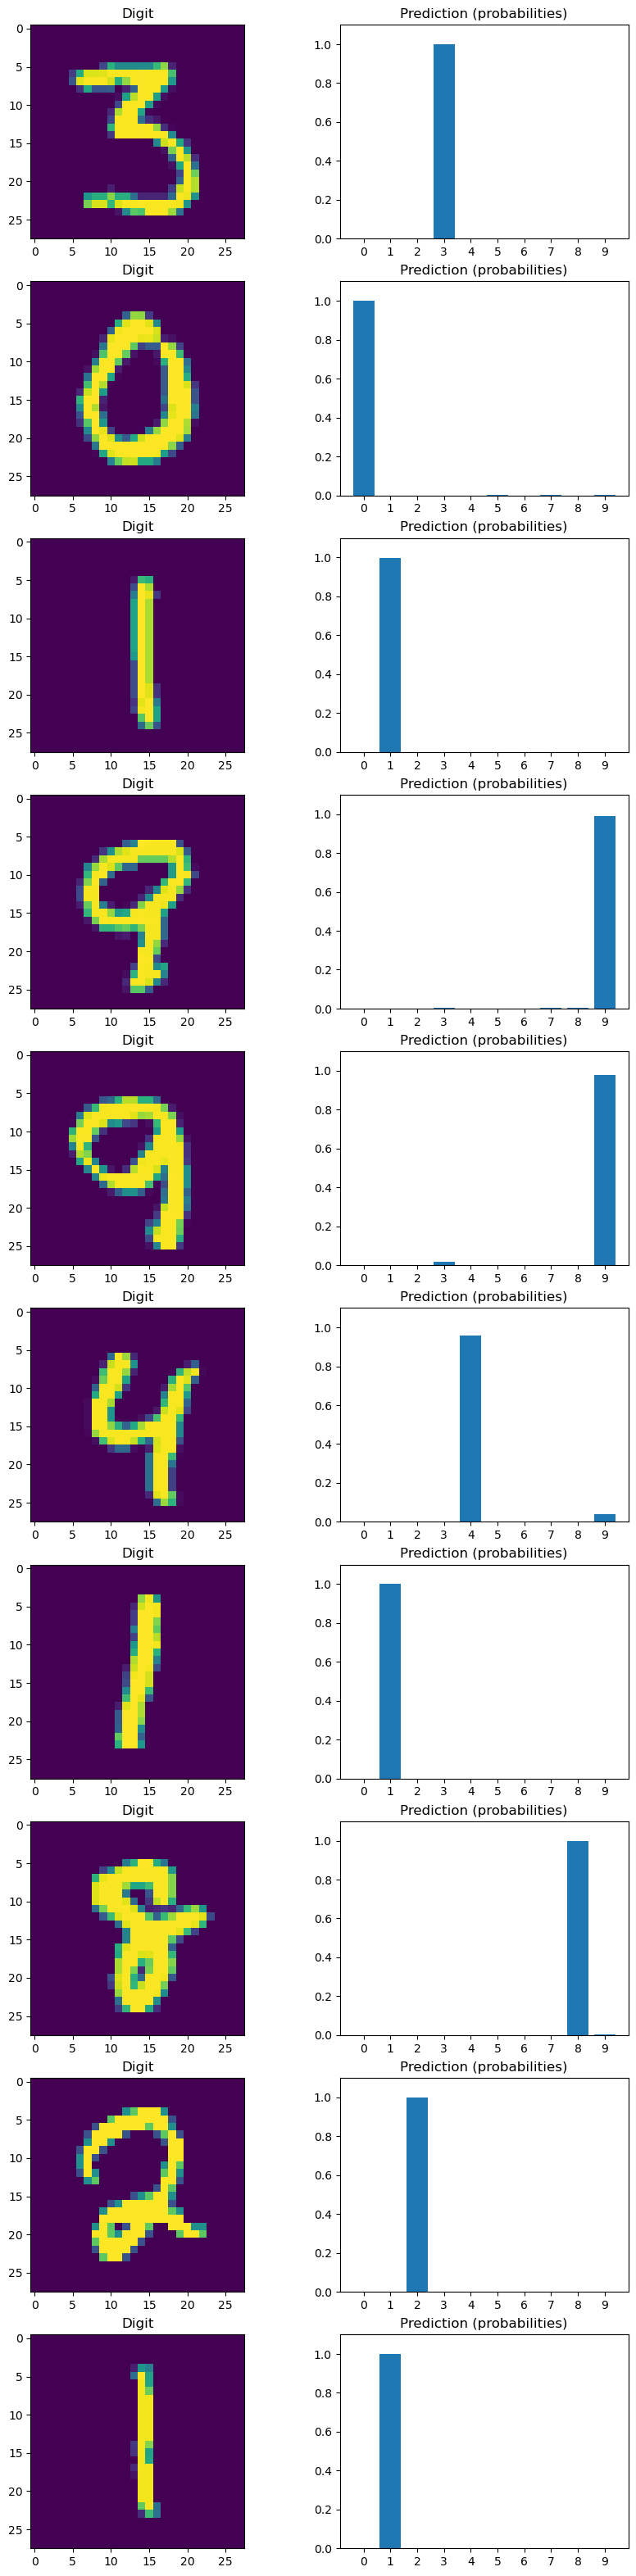

In [43]:
n = 27
inputs  = test_images[n*batch_size : (n+1)*batch_size,:].reshape(batch_size, 28, 28)
outputs = predictions[n*batch_size : (n+1)*batch_size,:]

f, ax = plt.subplots(batch_size,2, figsize=(10,4*batch_size))
for i in range(batch_size):
    ax[i,0].imshow(inputs[i,:,:])
    ax[i,0].set_title("Digit")
    ax[i,1].bar(range(10), outputs[i,:])
    ax[i,1].set_title("Prediction (probabilities)")
    ax[i,1].set_xticks(range(10))
    ax[i,1].set_ylim((0,1.1))

plt.show()

## 1.6 Evaluation

Now let's check that our model performs well on the test set too:

(By default, network.evaluate() uses a batch size of 32)



In [45]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9722 - loss: 0.0951


In [46]:
print('test_acc:', test_acc)

test_acc: 0.9763000011444092


Our test set accuracy turns out to be 97.6% -- that's quite a bit lower than the training set accuracy (98.6%).
This gap between training accuracy and test accuracy is an example of "overfitting",
the fact that machine learning models tend to perform worse on new data than on their training data.
Overfitting will be a central topic in the next lesson.

## END OF PART ONE
We will continue from here in the second lesson

##### Execute the following code instead of passing the previous codes one-by-one for the second part of this lab

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical

In [2]:
# Necessary for reproducibility
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

# Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Network layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax')) # REMARK: softmax is for multi-class classification

# Loss function and optimizer
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)

# Prediction
predictions = network.predict(test_images)

# Evaluation
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7274 - loss: 0.9988
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9300 - loss: 0.2517
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9497 - loss: 0.1852
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9590 - loss: 0.1464
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9669 - loss: 0.1200
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9721 - loss: 0.1006
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9767 - loss: 0.0855
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9795 - loss: 0.0737
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9826 - loss: 0.0642
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9853 - loss: 0.0564
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9724 - loss: 0.0951
test_acc: 0.9764000177383423


## ===== Exercise 1 =====

We were using one hidden layer with 512 units.
1. Try to use the current hidden layer with more hidden units.
2. Try to use the current hidden layer with less hidden units.
3. Try to add one more hidden layer.
4. Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.
5. Try to use the `mse` loss function instead of `categorical_crossentropy`.
6. Try to use no hidden layer at all.
7. Try to use two more hidden layers.

See how these modifications affect the test accuracy.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be improved!

---

##### Copy-paste the following code for each sub-exercise and add/modify/delete the necessary parts

In [53]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7274 - loss: 0.9988
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9300 - loss: 0.2517
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9497 - loss: 0.1852
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9590 - loss: 0.1464
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9669 - loss: 0.1200
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9721 - loss: 0.1006
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9766 - loss: 0.0856
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9794 - loss: 0.0737
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9827 - loss: 0.0642
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9855 - loss: 0.0564
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9722 - loss: 0.0951
test_acc: 0.9763000011444092


##### 1. Modify the current hidden layer with more hidden units

In [19]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))  # ---MODIFY CODE HERE---
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7503 - loss: 0.8674
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9389 - loss: 0.2182
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9576 - loss: 0.1530
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9684 - loss: 0.1161
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9748 - loss: 0.0915
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9801 - loss: 0.0740
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9837 - loss: 0.0610
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9870 - loss: 0.0509
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9896 - loss: 0.0429
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9914 - loss: 0.0365
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9768 - loss: 0.0811
test_acc: 0.9797000288963318


##### 2. Modify the current hidden layer with less hidden units

In [57]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(32, activation='relu', input_shape=(28 * 28,)))  # ---MODIFY CODE HERE---
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5272 - loss: 1.5854
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8675 - loss: 0.5137
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8981 - loss: 0.3751
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9093 - loss: 0.3264
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9165 - loss: 0.2997
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9217 - loss: 0.2811
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9256 - loss: 0.2666
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9296 - loss: 0.2541
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9334 - loss: 0.2430
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9362 - loss: 0.2328
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9235 - loss: 0.2573
test_acc: 0.9350000023841858


##### 3. Add a hidden layer with 64 units

In [59]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(64, activation='relu'))  # ---ADD CODE HERE---
# We have added a hidden layer with 64 units, we do not have to specify input_shape for other hidden layers
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc) # test_acc: 0.9771999716758728

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7188 - loss: 1.0035
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9379 - loss: 0.2189
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9570 - loss: 0.1527
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9680 - loss: 0.1136
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9750 - loss: 0.0874
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9806 - loss: 0.0696
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9849 - loss: 0.0574
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9871 - loss: 0.0486
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9895 - loss: 0.0412
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9909 - loss: 0.0353
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9732 - loss: 0.0861
test_acc: 0.9771999716758728


##### 4. Use `tanh` instead of `relu`

In [61]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(512, activation='tanh', input_shape=(28 * 28,)))  # ---MODIFY CODE HERE---
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7204 - loss: 0.9418
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9127 - loss: 0.3045
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9264 - loss: 0.2627
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9351 - loss: 0.2319
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9427 - loss: 0.2036
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9502 - loss: 0.1785
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9553 - loss: 0.1570
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9609 - loss: 0.1389
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9654 - loss: 0.1235
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9692 - loss: 0.1104
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9606 - loss: 0.1378
test_acc: 0.9664999842643738


##### 5. Use `mse` instead of `categorical_crossentropy`

In [63]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # ---MODIFY CODE HERE---
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7094 - loss: 0.0429
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9304 - loss: 0.0110
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9505 - loss: 0.0082
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9602 - loss: 0.0066
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9678 - loss: 0.0055
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9728 - loss: 0.0047
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9774 - loss: 0.0041
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9808 - loss: 0.0035
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9832 - loss: 0.0031
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9857 - loss: 0.0027
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9708 - loss: 0.0046
test_acc: 0.9757000207901001


##### 6. No hidden layer

In [9]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()  
network.add(layers.Dense(10, activation='softmax', input_shape=(28 * 28,))) # ---MODIFY CODE HERE---

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4313 - loss: 1.8555
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8229 - loss: 0.8250
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8597 - loss: 0.6007
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8750 - loss: 0.5059
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8847 - loss: 0.4523
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8909 - loss: 0.4175
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8963 - loss: 0.3928
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8997 - loss: 0.3743
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9038 - loss: 0.3598
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9070 - loss: 0.3482
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8967 - loss: 0.3765
test_acc: 0.9114999771118164


##### 7. Add two more hidden layers

In [133]:
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(64, activation='relu'))  # ---ADD CODE HERE---
network.add(layers.Dense(32, activation='relu'))  # ---ADD CODE HERE---
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_images, train_labels, epochs=10, batch_size=1000)
predictions = network.predict(test_images)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6997 - loss: 1.1044
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9351 - loss: 0.2290
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9572 - loss: 0.1531
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9675 - loss: 0.1144
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9740 - loss: 0.0901
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9796 - loss: 0.0730
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9832 - loss: 0.0608
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9852 - loss: 0.0509
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9888 - loss: 0.0415
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9908 - loss: 0.0340
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9739 - loss: 0.0896
test_acc: 0.9778000116348267


# 2. Handwritten Digit Recognition

In this section, you will build an algorithm for handwritten digit recognition. The workflow consists of the following steps.

 - Take an image as the input.

 - Find all the handwritten digits.

 - Convert each digit into its numerical value.

If you use Colab, we need to mount the Google Drive, to load the data that are on your GDrive account. This is done with the following code.
Uncomment the following code if you execute this exercise on Colab.

In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2.1 Digit extraction

The first step is to highlight the digits contained in the input image. This can be done as follows.

In [72]:
# If you do not use Colab, it would be better to install it via the terminal. Uncomment the following code if you execute this exercise on Colab.
# pip install opencv-python

In [73]:
# If you do not use Colab, it would be better to install it via the terminal. Uncomment the following code if you execute this exercise on Colab.
# pip install joblib

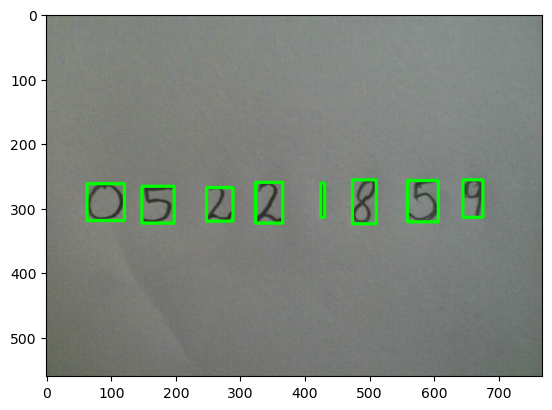

In [5]:
import cv2
#from sklearn.externals import joblib ### Old version
import joblib ## New version
import numpy as np
import matplotlib.pyplot as plt

# read the image
im = cv2.imread("./data/photo1.jpg") # ----Change this to the location of your own data----
# OR if you use Colab, uncomment the following code instead of the previos code:
# im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP2/data/photo1.jpg") # Change this to the location of your own data

if im is None:
    print("Error: Image not found or unable to load!")
else:
    # Convert the image to grayscale and apply Gaussian filtering
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours in the image
    ctrs, hierarchy = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get rectangles containing each contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    # draw a rectangle around the detected digits
    for rect in rects:
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)

plt.imshow(im)
plt.show()

Execute the code below to extract and display the single digits.

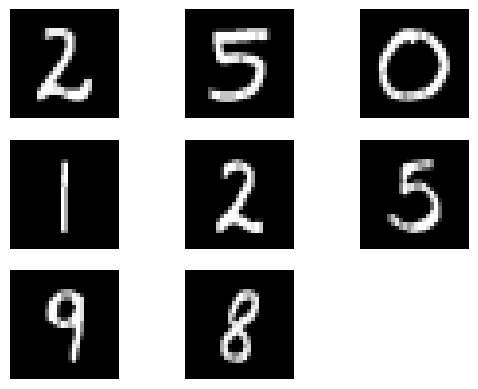

In [76]:
for i, rect in enumerate(rects):

    # Exctract the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    # Fit it to a 28x28 image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))

    # show
    plt.subplot(3, 3, i+1)
    plt.imshow(roi, cmap='gray')
    plt.axis('off')

plt.show()

## 2.2 Digit classification

The second step is to convert each handwritted digit into its corresponding numerical value. To do so, you will use the neural network trained on MNIST dataset. The following function puts everything together.

## ===== Exercise 2 =====

In the following function, complete the lines with the comment `# ADD CODE HERE`.

In [13]:
def detect_digits(image_name, model):

    # read the image
    im = cv2.imread(image_name)

    # Convert the image to grayscale and apply Gaussian filtering
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the image
    ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get rectangles containing each contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]

    # extract the digits
    for rect in rects:

        # Draw the rectangles
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)

        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

        if roi.shape[0] < 28 or roi.shape[1] < 28:
            continue

        # Resize the image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))

        # classify the image
        roi = roi.astype('float32')

        # 1. Reshape for one image and normalize 'roi'
        roi = roi.reshape(1, 28*28) / 255  # ADD CODE HERE
        # Reshape to (1, 28*28) for a single sample (from a 28x28 image into a 1D vector of size 784) 
        # Normalize pixel values to [0, 1]        

        # 2. Use 'model' to make a prediction
        probas = model.predict(roi)  # ADD CODE HERE

        # 3. Based on the prediction, determine the class (a number between 0 and 9)
        number = np.argmax(probas)  # ADD CODE HERE

        # draw the digit
        cv2.putText(im, str(number), (rect[0], rect[1]-5), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 0, 0), 3)

    # show the result
    plt.imshow(im)
    plt.show()

Run the following code to test.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


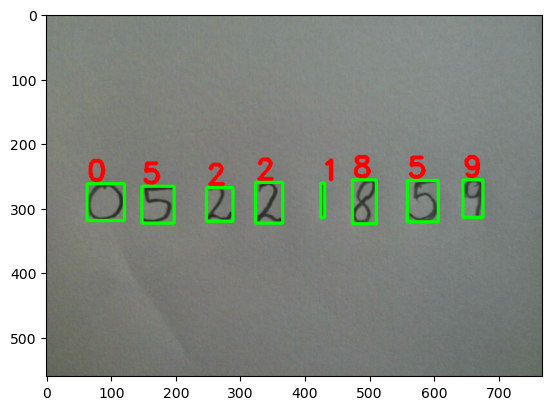

In [134]:
# detect_digits("/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP2/data/photo1.jpg", network)
detect_digits("./data/photo1.jpg", network)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


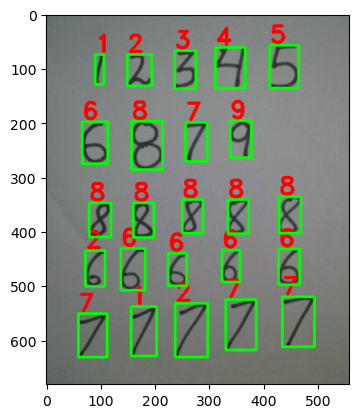

In [135]:
# detect_digits("/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP2/data/photo2.jpg", network)
detect_digits("./data/photo2.jpg", network)

## ===== Exercise (optional) =====

- Write down some numbers on a paper, and take a picture with your phone.

- Use your model 'network' to recognize the digits on the scanned photos.

---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


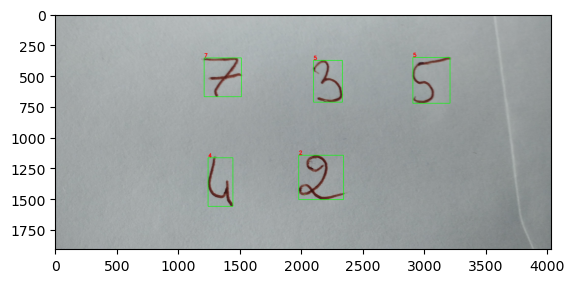

In [139]:
# detect_digits("/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP2/data/photo3.jpeg", network)
detect_digits("./data/photo3.jpg", network)

# 3. Conclusion


Here's what you should take away from this tutorial.

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it into a neural network.


* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.


* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems, and you will likely use them frequently.


* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, i.e. the output of your network should be a scalar between 0 and 1, encoding a probability. The loss function you should use is `binary_crossentropy`.


* In a multiclass classification problem (`K` output classes), your network should end with a `Dense` layer with `K` units and a `softmax` activation, i.e. the output of your network should be a probability distribution. The loss function you should use is `categorical_crossentropy`. In addition, you need to one-hot encode the labels before using them for training the network.


* In a regression problem, your network should end with a `Dense` layer with **no** activation, i.e. the output of your network should be unbounded. The loss function you should use is `mean_squared_error`.


* The `adam` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry  about.


In the next lesson, you will acquire a more formal understanding of some of the concepts you have encountered in these first examples, such as data preprocessing, model evaluation, and overfitting.